In [7]:
import glob
from itertools import product
import itertools


from joblib import Parallel, delayed
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sourmash import signature as sig
from tqdm import tqdm

%matplotlib inline

In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import common

figure_folder = common.get_figure_folder()
! mkdir -p $figure_folder
figure_folder

'../figures/084_analyze_tissue_subset_scaled_and_numhashes'

## Load signature subset

In [1]:
import time

In [3]:
t0 = time.time()


In [4]:
t1 = time.time()

In [5]:
tdelta = time.time() - t0
tdelta

10.960232496261597

In [6]:
%%time

import pickle
folder = '/home/olga/scratch/maca/facs/sourmash_compute_tissue_subset/'

pickle_filename = f'{folder}/siglist_subset_npergroup10.pickle'

with open(pickle_filename, 'rb') as f:
    siglist_all = pickle.load(f)

In [5]:
ksizes = 21, 27, 33, 51

In [98]:
2+2

4

In [99]:
s.d

{'class': 'sourmash_signature',
 'license': 'CC0',
 'name': 'O1-B002771-3_39_F-1-1|tissue:Bladder|subtissue:NA|cell_ontology_class:bladder_cell|free_annotation:Bladder_mesenchymal_cell',
 'filename': '/arg/2/1'}

In [100]:
s.minhash.num

1000000

In [101]:
len(siglist_all)

398

In [102]:
s = siglist_all[0]
s.name


<bound method SourmashSignature.name of SourmashSignature('D16-B000610-3_56_F-1-1|tissue:Bladder|subtissue:NA|cell_ontology_class:bladder_cell|free_annotation:Bladder_mesenchymal_cell', 95b877f3)>

In [103]:
dir(s)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_display_name',
 '_save',
 'contained_by',
 'd',
 'jaccard',
 'md5sum',
 'minhash',
 'name',
 'similarity']

In [104]:
dir(s.minhash)

['__class__',
 '__copy__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__ne__',
 '__new__',
 '__pyx_vtable__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'add',
 'add_hash',
 'add_many',
 'add_protein',
 'add_sequence',
 'compare',
 'contained_by',
 'copy_and_clear',
 'count_common',
 'downsample_max_hash',
 'downsample_n',
 'downsample_scaled',
 'get_hashes',
 'get_mins',
 'intersection',
 'is_molecule_type',
 'is_protein',
 'jaccard',
 'ksize',
 'max_hash',
 'merge',
 'num',
 'scaled',
 'seed',
 'set_abundances',
 'similarity',
 'similarity_ignore_maxhash',
 'subtract_mins',
 'track_abundance',
 'update']

In [105]:
for s in siglist_all[:10]:
    print('---')
    print(f's.minhash.ksize: {s.minhash.ksize}')
    print(f's.minhash.is_protein: {s.minhash.is_protein}')

---
s.minhash.ksize: 21
s.minhash.is_protein: True
---
s.minhash.ksize: 21
s.minhash.is_protein: False
---
s.minhash.ksize: 27
s.minhash.is_protein: True
---
s.minhash.ksize: 27
s.minhash.is_protein: False
---
s.minhash.ksize: 33
s.minhash.is_protein: True
---
s.minhash.ksize: 33
s.minhash.is_protein: False
---
s.minhash.ksize: 51
s.minhash.is_protein: True
---
s.minhash.ksize: 51
s.minhash.is_protein: False
---
s.minhash.ksize: 21
s.minhash.is_protein: True
---
s.minhash.ksize: 21
s.minhash.is_protein: False


In [106]:
nrow = ncol = len(siglist)

NameError: name 'siglist' is not defined

In [ ]:
import jaccard_utils

In [ ]:
cat jaccard_utils.py

In [ ]:
# %%time

# n_jobs = 8

# values = Parallel(n_jobs=n_jobs)(delayed(jaccard_utils.jaccard_sigs)(i, j, siglist) 
#                                  for i, j in itertools.product(range(len(siglist)), range(len(siglist))))

In [107]:
import itertools

from scipy.spatial.distance import squareform


def _compare_serial(siglist, iterator):
    n = len(siglist)
    values = np.ones((n, n))
    
    for i, j in iterator:
        jaccard = jaccard_utils.jaccard_sigs(i, j, siglist)
        
        values[i, j] = jaccard
        values[j, i] = jaccard
        
    return values


def compare_all_pairs(siglist, n_jobs=None):
    n = len(siglist)
    iterator = itertools.combinations(range(n), 2)
    
    
    if n_jobs is None:
        values = _compare_serial(siglist, iterator)
    else:
        # This creates a condensed distance matrix
        condensed = Parallel(n_jobs=n_jobs)(delayed(jaccard_utils.jaccard_sigs)(i, j, siglist) for i, j in iterator)
        values = squareform(condensed)
        
    return values



In [108]:
def filter_siglist(siglist, ksize, moltype):
    if moltype == 'protein':
        molfilter = lambda x: x.minhash.is_protein
    else:
        molfilter = lambda x: not x.minhash.is_protein
    
    return [s for s in siglist if molfilter(s) and (s.minhash.ksize == ksize)]


In [109]:
siglist_k27_dna = filter_siglist(siglist_all, 27, "DNA")
print(len(siglist_k27_dna))
siglist_k27_dna[:5]

49


[SourmashSignature('D16-B000610-3_56_F-1-1|tissue:Bladder|subtissue:NA|cell_ontology_class:bladder_cell|free_annotation:Bladder_mesenchymal_cell', 3e5edf55),
 SourmashSignature('J8-D041914-3_8_M-1-1|tissue:Bladder|subtissue:NA|cell_ontology_class:bladder_cell|free_annotation:Bladder_mesenchymal_cell', 743c7b8e),
 SourmashSignature('A10-D041914-3_8_M-1-1|tissue:Bladder|subtissue:NA|cell_ontology_class:bladder_cell|free_annotation:Bladder_mesenchymal_cell', b5888448),
 SourmashSignature('K1-B000610-3_56_F-1-1|tissue:Bladder|subtissue:NA|cell_ontology_class:bladder_cell|free_annotation:Bladder_mesenchymal_cell', 6075f17a),
 SourmashSignature('O1-B002771-3_39_F-1-1|tissue:Bladder|subtissue:NA|cell_ontology_class:bladder_cell|free_annotation:Bladder_mesenchymal_cell', c4e34c88)]

In [111]:
any(s.minhash.is_protein for s in siglist_k27_dna)

False

In [112]:
%time values = compare_all_pairs(siglist_k27_dna)
values

CPU times: user 12min 35s, sys: 26 s, total: 13min 1s
Wall time: 13min 52s


array([[1.      , 0.075768, 0.070774, ..., 0.040544, 0.044088, 0.0395  ],
       [0.075768, 1.      , 0.110656, ..., 0.047962, 0.047579, 0.043913],
       [0.070774, 0.110656, 1.      , ..., 0.048923, 0.047328, 0.043935],
       ...,
       [0.040544, 0.047962, 0.048923, ..., 1.      , 0.054105, 0.049739],
       [0.044088, 0.047579, 0.047328, ..., 0.054105, 1.      , 0.050342],
       [0.0395  , 0.043913, 0.043935, ..., 0.049739, 0.050342, 1.      ]])

In [117]:
# %time values = compare_all_pairs(siglist_k27_dna, n_jobs=8)
# values

In [118]:
1+2

3

In [114]:
# scaled = 200
# %time siglist_k27_dna_downsampled = [s.minhash.downsample_scaled(scaled) for s in siglist_k27_dna]
# print(len(siglist_k27_dna_downsampled))
# siglist_k27_dna_downsampled[:5]

In [115]:
num_hashes = 1000

%time siglist_k27_dna_downsampled_num_hashes = [s.minhash.downsample_n(num_hashes) for s in siglist_k27_dna]
print(len(siglist_k27_dna_downsampled_num_hashes))
siglist_k27_dna_downsampled_num_hashes[:5]

CPU times: user 20.2 s, sys: 6.56 s, total: 26.8 s
Wall time: 26.8 s
49


In [116]:
%time values_numhashes = compare_all_pairs(siglist_k27_dna_downsampled_num_hashes)
values_numhashes

CPU times: user 432 ms, sys: 20 ms, total: 452 ms
Wall time: 555 ms


array([[1.   , 0.077, 0.061, ..., 0.025, 0.039, 0.031],
       [0.077, 1.   , 0.099, ..., 0.043, 0.046, 0.038],
       [0.061, 0.099, 1.   , ..., 0.058, 0.041, 0.04 ],
       ...,
       [0.025, 0.043, 0.058, ..., 1.   , 0.063, 0.056],
       [0.039, 0.046, 0.041, ..., 0.063, 1.   , 0.045],
       [0.031, 0.038, 0.04 , ..., 0.056, 0.045, 1.   ]])

In [119]:
import knn


In [120]:
annotations = pd.read_csv("/home/olga/tabula-muris/00_data_ingest/18_global_annotation_csv/annotations_facs.csv")
annotations['cell'] = annotations['cell'].str.replace('.', '-')
print(annotations.shape)
annotations.head()

(44949, 24)


/home/olga/miniconda3/envs/kmer-hashing/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Neurog3>0_raw,Neurog3>0_scaled,cell,cell_ontology_class,cell_ontology_id,cluster.ids,free_annotation,mouse.id,mouse.sex,plate.barcode,...,subsetC,subsetC_cluster.ids,subsetD,subsetD_cluster.ids,subsetE,subsetE_cluster.ids,subtissue,tissue,tissue_tSNE_1,tissue_tSNE_2
0,NaN,NaN,A1-B000610-3_56_F-1-1,bladder cell,CL:1001319,5,Bladder mesenchymal cell,3_56_F,F,B000610,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bladder,-7.182841,-10.895094
1,NaN,NaN,A1-B002764-3_38_F-1-1,bladder urothelial cell,CL:1001428,3,Luminal bladder epithelial cell,3_38_F,F,B002764,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bladder,4.199059,-11.050240
2,NaN,NaN,A1-B002771-3_39_F-1-1,bladder cell,CL:1001319,5,Bladder mesenchymal cell,3_39_F,F,B002771,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bladder,-11.995435,-7.325534
3,NaN,NaN,A1-D041914-3_8_M-1-1,bladder cell,CL:1001319,5,Bladder mesenchymal cell,3_8_M,M,D041914,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bladder,-6.820022,-14.174246
4,NaN,NaN,A1-D042253-3_9_M-1-1,bladder cell,CL:1001319,2,Bladder mesenchymal cell,3_9_M,M,D042253,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bladder,-24.163538,-7.499349


In [121]:
cell_ids_k27_dna = [s.name().split('|')[0] for s in siglist_k27_dna]
cell_ids_k27_dna[:5]

['D16-B000610-3_56_F-1-1',
 'J8-D041914-3_8_M-1-1',
 'A10-D041914-3_8_M-1-1',
 'K1-B000610-3_56_F-1-1',
 'O1-B002771-3_39_F-1-1']

In [122]:
metadata = annotations.query('cell in @cell_ids_k27_dna').set_index('cell')
print(metadata.shape)
metadata.head()

(49, 23)


,Neurog3>0_raw,Neurog3>0_scaled,cell_ontology_class,cell_ontology_id,cluster.ids,free_annotation,mouse.id,mouse.sex,plate.barcode,subsetA,...,subsetC,subsetC_cluster.ids,subsetD,subsetD_cluster.ids,subsetE,subsetE_cluster.ids,subtissue,tissue,tissue_tSNE_1,tissue_tSNE_2
cell,,,,,,,,,,,,,,,,,,,,,
A10-D041914-3_8_M-1-1,NaN,NaN,bladder cell,CL:1001319,2,Bladder mesenchymal cell,3_8_M,M,D041914,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bladder,-16.643703,-2.434115
C1-B002771-3_39_F-1-1,NaN,NaN,bladder cell,CL:1001319,0,Bladder mesenchymal cell,3_39_F,F,B002771,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bladder,6.323991,-20.799954
D16-B000610-3_56_F-1-1,NaN,NaN,bladder cell,CL:1001319,5,Bladder mesenchymal cell,3_56_F,F,B000610,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bladder,-3.680862,-7.935199
G2-MAA000487-3_10_M-1-1,NaN,NaN,bladder cell,CL:1001319,0,Bladder mesenchymal cell,3_10_M,M,MAA000487,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bladder,-7.573929,-25.838321
H2-D041914-3_8_M-1-1,NaN,NaN,bladder cell,CL:1001319,2,Bladder mesenchymal cell,3_8_M,M,D041914,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bladder,-19.457846,7.086368


In [123]:
jaccard_1m = pd.DataFrame(values, index=cell_ids_k27_dna, columns=cell_ids_k27_dna)
jaccard_1m.head()

,D16-B000610-3_56_F-1-1,J8-D041914-3_8_M-1-1,A10-D041914-3_8_M-1-1,K1-B000610-3_56_F-1-1,O1-B002771-3_39_F-1-1,H2-D041914-3_8_M-1-1,C1-B002771-3_39_F-1-1,P2-B000610-3_56_F-1-1,I6-D041914-3_8_M-1-1,G2-MAA000487-3_10_M-1-1,...,O18-MAA001862-3_39_F-1-1,M13-B001750-3_38_F-1-1,C16-B000971-3_39_F-1-1,L19-B001750-3_38_F-1-1,A19-B000971-3_39_F-1-1,K4-MAA000508-3_9_M-1-1,D22-MAA000776-3_10_M-1-1,I20-B000971-3_39_F-1-1,G4-B001750-3_38_F-1-1,G10-B001750-3_38_F-1-1
D16-B000610-3_56_F-1-1,1.000000,0.075768,0.070774,0.075483,0.061413,0.084365,0.079117,0.082958,0.074517,0.055713,...,0.048662,0.040939,0.037233,0.042356,0.037722,0.038222,0.033112,0.040544,0.044088,0.039500
J8-D041914-3_8_M-1-1,0.075768,1.000000,0.110656,0.095762,0.094588,0.113787,0.110328,0.087658,0.107888,0.095467,...,0.080262,0.047532,0.040653,0.043899,0.044750,0.039540,0.039569,0.047962,0.047579,0.043913
A10-D041914-3_8_M-1-1,0.070774,0.110656,1.000000,0.089041,0.084941,0.114014,0.096012,0.083851,0.113230,0.095182,...,0.077649,0.047329,0.041871,0.043327,0.045125,0.038878,0.039886,0.048923,0.047328,0.043935
K1-B000610-3_56_F-1-1,0.075483,0.095762,0.089041,1.000000,0.080479,0.093818,0.096238,0.083216,0.086865,0.078582,...,0.068187,0.044781,0.037555,0.040809,0.041846,0.037676,0.034827,0.044738,0.044295,0.040594
O1-B002771-3_39_F-1-1,0.061413,0.094588,0.084941,0.080479,1.000000,0.086823,0.088497,0.068989,0.084056,0.081769,...,0.066603,0.040245,0.035381,0.036368,0.039008,0.032765,0.033826,0.042489,0.039067,0.037353


In [124]:
jaccard_1k = pd.DataFrame(values_numhashes, index=cell_ids_k27_dna, columns=cell_ids_k27_dna)
jaccard_1k.head()

,D16-B000610-3_56_F-1-1,J8-D041914-3_8_M-1-1,A10-D041914-3_8_M-1-1,K1-B000610-3_56_F-1-1,O1-B002771-3_39_F-1-1,H2-D041914-3_8_M-1-1,C1-B002771-3_39_F-1-1,P2-B000610-3_56_F-1-1,I6-D041914-3_8_M-1-1,G2-MAA000487-3_10_M-1-1,...,O18-MAA001862-3_39_F-1-1,M13-B001750-3_38_F-1-1,C16-B000971-3_39_F-1-1,L19-B001750-3_38_F-1-1,A19-B000971-3_39_F-1-1,K4-MAA000508-3_9_M-1-1,D22-MAA000776-3_10_M-1-1,I20-B000971-3_39_F-1-1,G4-B001750-3_38_F-1-1,G10-B001750-3_38_F-1-1
D16-B000610-3_56_F-1-1,1.000,0.077,0.061,0.070,0.055,0.080,0.072,0.078,0.063,0.056,...,0.036,0.027,0.027,0.033,0.027,0.030,0.020,0.025,0.039,0.031
J8-D041914-3_8_M-1-1,0.077,1.000,0.099,0.102,0.092,0.113,0.108,0.084,0.108,0.103,...,0.073,0.043,0.037,0.049,0.041,0.037,0.029,0.043,0.046,0.038
A10-D041914-3_8_M-1-1,0.061,0.099,1.000,0.088,0.088,0.126,0.089,0.082,0.115,0.097,...,0.071,0.043,0.038,0.045,0.046,0.038,0.037,0.058,0.041,0.040
K1-B000610-3_56_F-1-1,0.070,0.102,0.088,1.000,0.065,0.093,0.084,0.087,0.075,0.076,...,0.062,0.042,0.032,0.039,0.030,0.035,0.028,0.038,0.039,0.031
O1-B002771-3_39_F-1-1,0.055,0.092,0.088,0.065,1.000,0.081,0.079,0.070,0.079,0.076,...,0.059,0.036,0.036,0.037,0.042,0.033,0.025,0.045,0.031,0.029


In [140]:



palettes = dict(tissue='husl', cell_ontology_class='tab10')
color_cols = ['cell_ontology_class', 'tissue']




n_neighbors = 5

graph_1m = knn.nearest_neighbor_graph(jaccard_1m, metadata, n_neighbors=n_neighbors, 
                                      color_cols=color_cols, palettes=palettes)
graph_1m

In [141]:
metadata.groupby('tissue').apply(lambda x: x['cell_ontology_class'].mode()[0])

tissue
Bladder                           bladder cell
Kidney      epithelial cell of proximal tubule
Liver                               hepatocyte
Pancreas                type B pancreatic cell
Spleen                                  B cell
dtype: object

In [142]:
import networkx as nx

/home/olga/miniconda3/envs/kmer-hashing/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


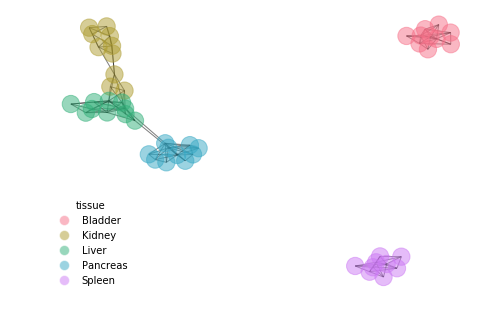

In [143]:
pos = nx.spring_layout(graph_1m, seed=0)

label = 'tissue'
knn.draw_graph(graph_1m, edge_color='black', pos=pos, label_col=label,)

/home/olga/miniconda3/envs/kmer-hashing/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


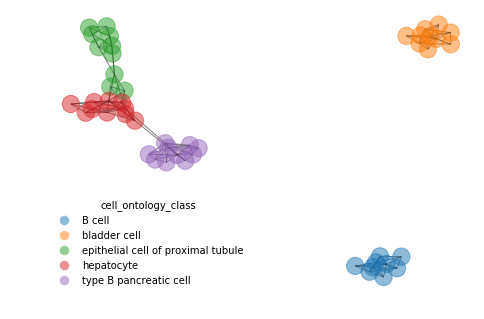

In [144]:
pos = nx.spring_layout(graph_1m, seed=0)

label = 'cell_ontology_class'
knn.draw_graph(graph_1m, edge_color='black', pos=pos, label_col=label,)

In [145]:
graph == graph_1m

False

/home/olga/miniconda3/envs/kmer-hashing/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/home/olga/miniconda3/envs/kmer-hashing/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/home/olga/miniconda3/envs/kmer-hashing/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/home/olga/miniconda3/envs/kmer-hashing/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


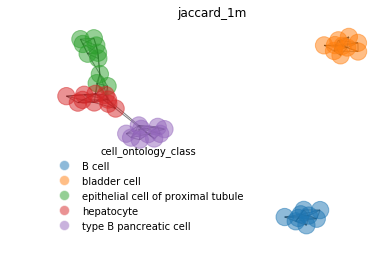

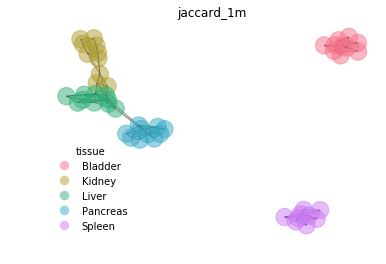

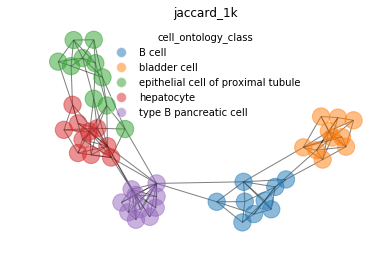

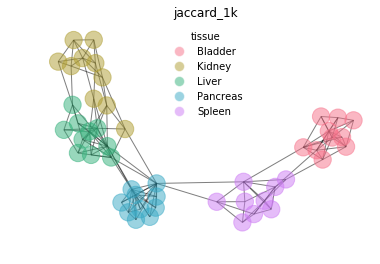

In [146]:
jaccards = dict(jaccard_1m=jaccard_1m, jaccard_1k=jaccard_1k)


for name, data in jaccards.items():
    graph = knn.nearest_neighbor_graph(data, metadata, n_neighbors=n_neighbors, 
                                      color_cols=color_cols, palettes=palettes)
    pos = nx.spring_layout(graph, seed=0)

    for label in color_cols:
        fig, ax = plt.subplots()
        knn.draw_graph(graph, edge_color='black', pos=pos, label_col=label,)
        ax.set_title(name)

In [132]:
compare_vanilla = pd.DataFrame(values, index=names, columns=names)
compare_vanilla.head()

NameError: name 'names' is not defined

In [ ]:
%%time
n_jobs = 8

values_idf = Parallel(n_jobs=n_jobs)(delayed(jaccard_sigs_idf)(i, j, siglist, inverse_document_frequency, mean_idf_per_cell) 
                                 for i, j in itertools.product(range(nrow), range(ncol)))

In [ ]:
compare_idf = pd.DataFrame(values_idf, index=names, columns=names)